In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio

import torchaudio
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Model, Wav2Vec2Processor, Trainer, TrainingArguments, Wav2Vec2ForSequenceClassification

import warnings
warnings.filterwarnings('ignore')

## Loading the Dataset

In [2]:
paths = []
labels = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename.split('.')[-1] == 'txt':
            continue
        paths.append(os.path.join(dirname, filename))
        label = dirname.split('/')[-1]
        labels.append(label.lower())
print('Dataset is Loaded')

Dataset is Loaded


In [3]:
## Creating its dataframe

df = pd.DataFrame()
df['audio_paths'] = paths
df['labels'] = labels
df.head()

,audio_paths,labels
0,/kaggle/input/emotional-speech-dataset-esd/Emo...,surprise
1,/kaggle/input/emotional-speech-dataset-esd/Emo...,surprise
2,/kaggle/input/emotional-speech-dataset-esd/Emo...,surprise
3,/kaggle/input/emotional-speech-dataset-esd/Emo...,surprise
4,/kaggle/input/emotional-speech-dataset-esd/Emo...,surprise


In [4]:
for i in range(len(df['labels'])):
    if(df['labels'][i] == 'model-new'):
        df.drop(i, inplace=True)

In [5]:
df['labels'].value_counts()

labels
surprise    7000
angry       7000
neutral     7000
sad         7000
happy       7000
Name: count, dtype: int64

## Data Analysis

In [16]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

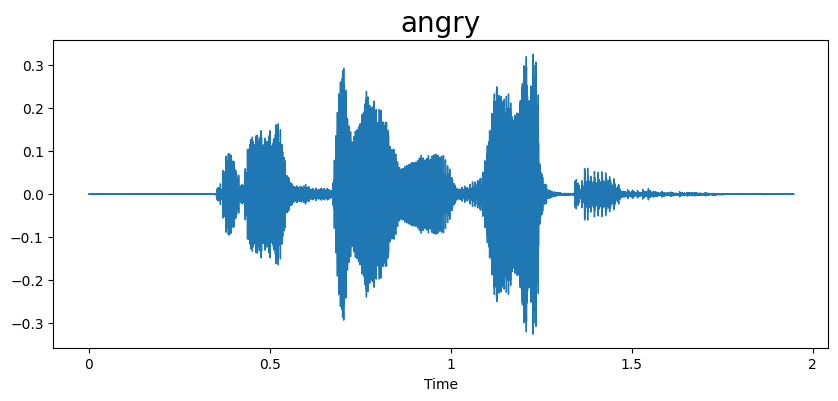

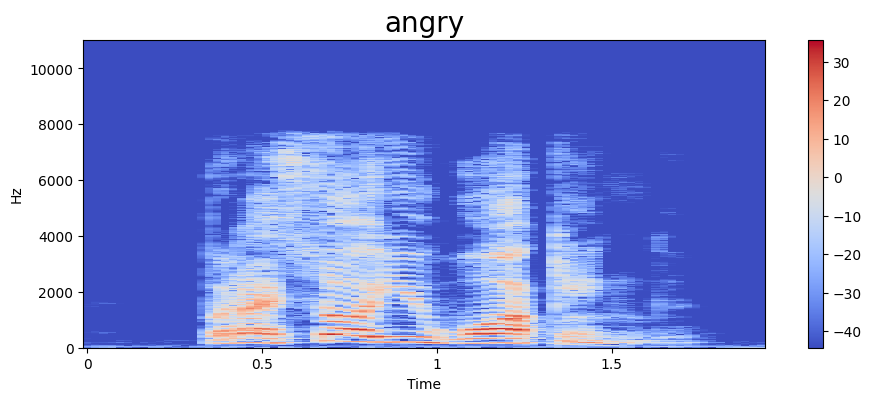

In [19]:
emotion = 'angry'
path = np.array(df['audio_paths'][df['labels'] == emotion])[0]
data, sr = librosa.load(path)
waveplot(data, sr, emotion)
spectogram(data, sr, emotion)
Audio(path)

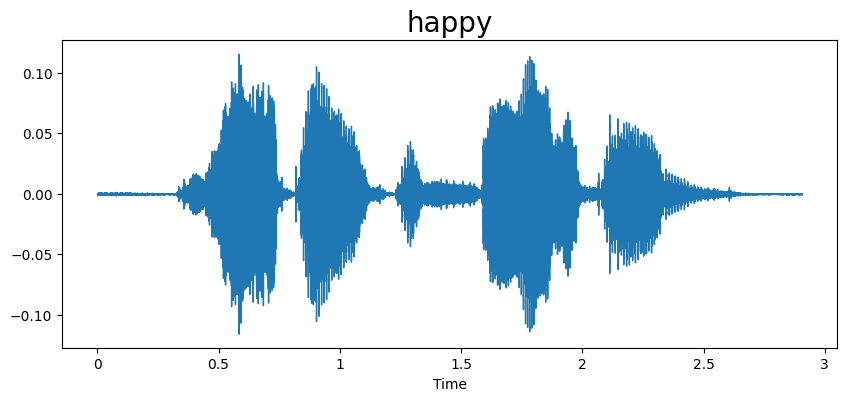

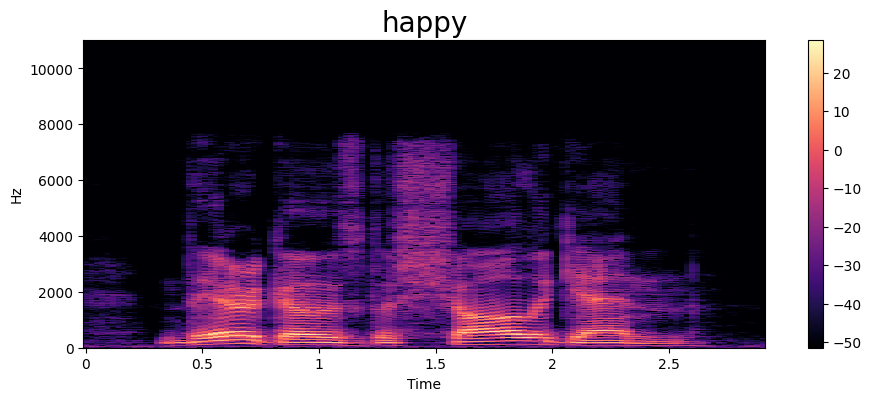

In [22]:
emotion = 'happy'
path = np.array(df['audio_paths'][df['labels'] == emotion])[100]
data, sr = librosa.load(path)
waveplot(data, sr, emotion)
spectogram(data, sr, emotion)
Audio(path)

## Creating Dataset Class

In [6]:
## Label -> Int map
label_map = {label: idx for idx,label in enumerate(df['labels'].unique())}
inverse_label_map = {idx: label for idx,label in label_map.items()}
df['labels'] = df['labels'].map(label_map)
df.head()

,audio_paths,labels
0,/kaggle/input/emotional-speech-dataset-esd/Emo...,0
1,/kaggle/input/emotional-speech-dataset-esd/Emo...,0
2,/kaggle/input/emotional-speech-dataset-esd/Emo...,0
3,/kaggle/input/emotional-speech-dataset-esd/Emo...,0
4,/kaggle/input/emotional-speech-dataset-esd/Emo...,0


In [7]:
inverse_label_map = {label: idx for idx,label in label_map.items()}
inverse_label_map

{0: 'surprise', 1: 'angry', 2: 'neutral', 3: 'sad', 4: 'happy'}

In [8]:
class SpeechEmotionDataset(Dataset):
    def __init__(self, df, processor, max_length=45000):
        self.df = df
        self.processor = processor
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        audio_path = self.df.iloc[idx]['audio_paths']
        label = self.df.iloc[idx]['labels']

        # load the audio file with sampling rate = 16000 (as per the facebook model)
        speech, sr = librosa.load(audio_path, sr = 16000)
        
        # pad or truncate the speech to the required length
        if len(speech) > self.max_length:
            speech = speech[:self.max_length]
        else:
            speech = np.pad(speech, (0, self.max_length - len(speech)), 'constant')

        # preprocess the audio file
        inputs = self.processor(speech, sampling_rate=16000, return_tensors='pt', padding=True, truncation=True, max_length=self.max_length)
        
        input_values = inputs.input_values.squeeze()
        return {'input_values': input_values, 'labels': torch.tensor(label, dtype=torch.long)}

In [9]:
## Split the data

from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size = 0.2, random_state = 42)

In [10]:
## Initialize the Processor and Model

processor = Wav2Vec2Processor.from_pretrained('facebook/wav2vec2-base')
model = Wav2Vec2ForSequenceClassification.from_pretrained('facebook/wav2vec2-base', num_labels = 5)

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
## Load datasets

train_dataset = SpeechEmotionDataset(train_df, processor)
test_dataset = SpeechEmotionDataset(test_df, processor)

In [12]:
## Create Dataloaders

train_dataloader = DataLoader(train_dataset, batch_size = 16, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = 16, shuffle = False)

## Setting Training Arguments

In [45]:
training_args = TrainingArguments(
    output_dir = './results',
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    learning_rate = 2e-5,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    num_train_epochs = 3,
    weight_decay = 0.01,
    report_to = []
)

In [46]:
## create functions for computing metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids  # original labels
    preds = np.argmax(pred.predictions, axis=1)  # model predicted labels
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [47]:
## Initialize the Trainer 

trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = test_dataset,
    compute_metrics = compute_metrics
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.250900,0.222781,0.934000,0.938551,0.934000,0.934033
2,0.128000,0.152781,0.965857,0.965897,0.965857,0.965786
3,0.068100,0.131607,0.972714,0.972771,0.972714,0.972715


TrainOutput(global_step=5250, training_loss=0.172486388978504, metrics={'train_runtime': 3004.7992, 'train_samples_per_second': 27.955, 'train_steps_per_second': 1.747, 'total_flos': 2.14484444748e+18, 'train_loss': 0.172486388978504, 'epoch': 3.0})

In [52]:
import random

idx = random.randrange(0, len(test_dataset))
print("Original Label:", inverse_label_map[int(test_dataset[idx]['labels'])])
input_values = test_dataset[idx]['input_values'].unsqueeze(0).to('cuda')

with torch.no_grad():
    outputs = model(input_values)
    logits = outputs.logits

predicted_class = logits.argmax(dim=1).item()
print('Predicted Label:', inverse_label_map[predicted_class])
logits

Original Label: neutral
Predicted Label: neutral


tensor([[-2.1517, -1.7853,  8.1309, -0.8668, -1.9215]], device='cuda:0')

## Calibration for Confidence Estimation

In [53]:
import torch
import torch.nn.functional as F

class TemperatureScaler(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Initialize temperature as a learnable parameter > 0
        self.temperature = torch.nn.Parameter(torch.ones(1))

    def forward(self, logits):
        # Scale logits by dividing by temperature
        return logits / self.temperature

def find_optimal_temperature(logits, labels):
    """
    Given model logits and labels on a calibration set,
    this function finds the optimal temperature that minimizes NLL.
    """
    # Move to GPU if available
    device = logits.device
    temperature_scaler = TemperatureScaler().to(device)

    # Use an optimizer to learn the temperature
    optimizer = torch.optim.LBFGS([temperature_scaler.temperature], lr=0.01, max_iter=50)

    nll_criterion = torch.nn.CrossEntropyLoss()

    def eval_step():
        optimizer.zero_grad()
        scaled_logits = temperature_scaler(logits)
        loss = nll_criterion(scaled_logits, labels)
        loss.backward()
        return loss

    # Run L-BFGS to optimize the temperature
    optimizer.step(eval_step)

    return temperature_scaler.temperature.item()


calibration_logits = []
calibration_labels = []

for i in range(0,len(test_dataset)):
    this_time = test_dataset[i]
    inp = this_time['input_values'].unsqueeze(0).to('cuda')
    lab = this_time['labels']
    with torch.no_grad():
        outputs = model(inp)
        logits = outputs.logits
    calibration_logits.append(logits.cpu())
    calibration_labels.append(lab.cpu())
    
calibration_logits = torch.cat(calibration_logits, dim = 0)
calibration_labels = torch.tensor(calibration_labels)

print(calibration_logits.shape)

torch.Size([7000, 5])


In [1]:
optimal_T = find_optimal_temperature(calibration_logits, calibration_labels)
print("Optimal Temperature:", optimal_T)

Optimal Temperature: 1.536


In [ ]:
import torch
import torch.nn.functional as F

def compute_logits_and_labels(model, dataset, device='cuda'):
    """
    Collect all logits and labels from a dataset using the given model.
    """
    all_logits = []
    all_labels = []
    
    model.eval()
    with torch.no_grad():
        for i in range(len(dataset)):
            sample = dataset[i]
            inp = sample['input_values'].unsqueeze(0).to(device)
            lab = sample['labels']
            
            outputs = model(inp)
            logits = outputs.logits
            
            all_logits.append(logits.cpu())
            all_labels.append(lab)
    
    all_logits = torch.cat(all_logits, dim=0)        # shape: [N, num_classes]
    all_labels = torch.tensor(all_labels, dtype=torch.long)  # shape: [N]
    return all_logits, all_labels


def compute_ece(probabilities, labels, n_bins=10):
    """
    Computes the Expected Calibration Error (ECE).
    probabilities: [N, num_classes] (tensor) 
    labels:        [N] (tensor)
    n_bins:        number of bins to bucket predictions by confidence
    """
    confidences, predictions = torch.max(probabilities, dim=1)
    
    # Convert to numpy for binning (or stay in torch, but numpy is simpler for binning)
    confidences = confidences.cpu().numpy()
    predictions = predictions.cpu().numpy()
    labels = labels.cpu().numpy()
    
    ece = 0.0
    bin_size = 1.0 / n_bins
    
    for i in range(n_bins):
        # Bin boundaries [i/n_bins, (i+1)/n_bins)
        lower = i * bin_size
        upper = (i + 1) * bin_size
        
        # Indices for which confidence falls into this bin
        mask = (confidences >= lower) & (confidences < upper)
        bin_count = np.sum(mask)
        if bin_count > 0:
            # Average confidence in this bin
            avg_confidence = np.mean(confidences[mask])
            # Average accuracy (fraction correct) in this bin
            avg_accuracy = np.mean(predictions[mask] == labels[mask])
            
            # Proportion of samples in this bin
            proportion = bin_count / len(confidences)
            # Accumulate ECE
            ece += np.abs(avg_accuracy - avg_confidence) * proportion
    
    return ece


model = Wav2Vec2ForSequenceClassification.from_pretrained("/kaggle/input/model-new")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

validation_logits, validation_labels = compute_logits_and_labels(model, test_dataset, device=device)

In [58]:
# 2. Compute probabilities BEFORE temperature scaling
probabilities_before = F.softmax(validation_logits, dim=-1)

# 3. Compute ECE before scaling
ece_before = compute_ece(probabilities_before, validation_labels, n_bins=10)
print("ECE before temperature scaling:", ece_before)

# 4. Suppose you already have an optimal temperature (optimal_T) 
#    from your temperature-scaling step.
optimal_T = 1.536

# 5. Compute scaled logits and probabilities AFTER temperature scaling
scaled_logits = validation_logits / optimal_T
probabilities_after = F.softmax(scaled_logits, dim=-1)

# 6. Compute ECE after scaling
ece_after = compute_ece(probabilities_after, validation_labels, n_bins=10)
print("ECE after temperature scaling:", ece_after)

ECE before temperature scaling: 0.021942525284630914
ECE after temperature scaling: 0.0033644491604396614


In [13]:
model = Wav2Vec2ForSequenceClassification.from_pretrained("/kaggle/input/model-new", output_hidden_states=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Wav2Vec2ForSequenceClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)


## Unknown Detection and Online Clustering done in pred_entropy.py and pred_openmax.py

## Below code to get OpenMax Params

In [33]:
import torch
import numpy as np
from collections import defaultdict
from scipy.stats import weibull_min
import pickle

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device).eval()

# 1) Gather penultimate activations per class
avs_per_class = defaultdict(list)

with torch.no_grad():
    for batch in train_dataloader:
        x = batch['input_values'].to(device)   # (B, L)
        y = batch['labels'].to(device)         # (B,)

        # 1a) Encoder output → mean‑pooled (B, H)
        hidden = model.wav2vec2(x).last_hidden_state  # (B, T, H)
        feats  = hidden.mean(1)      
        # 1c) ℓ₂‑normalize
        penult_np   = feats.cpu().numpy().squeeze()      # (B, H)
        norms       = np.linalg.norm(penult_np, axis=1, keepdims=True)
        penult_norm = penult_np / (norms + 1e-12)     # (B, H)

        # 1d) collect per‑class
        for vec, label in zip(penult_norm, y.cpu().numpy()):
            avs_per_class[int(label)].append(vec)

# 2) Compute class means, inverse covariances, and tail Weibulls
class_means, class_cov_invs, class_weibulls = {}, {}, {}
tail_fraction = 0.3
eps = 1e-6

for cls, vecs in avs_per_class.items():
    A = np.stack(vecs)                # (N_cls, H)
    mu = A.mean(axis=0)               # (H,)

    # 2a) covariance + regularization
    cov    = np.cov(A, rowvar=False) + np.eye(A.shape[1]) * eps
    invcov = np.linalg.inv(cov)       # (H, H)

    # 2b) Mahalanobis distances
    delta = A - mu                    # (N_cls, H)
    dists = np.sqrt(np.einsum('ij,ij->i', delta @ invcov, delta))

    # 2c) fit Weibull on top tail_fraction of distances
    k     = max(1, int(tail_fraction * len(dists)))
    tail  = np.sort(dists)[-k:]
    shape, loc, scale = weibull_min.fit(tail, floc=0)

    # store
    class_means[cls]    = mu
    class_cov_invs[cls] = invcov
    class_weibulls[cls] = (shape, loc, scale)

# 3) Save for inference
with open("openmax_params_new.pkl", "wb") as f:
    pickle.dump({
        "class_means": class_means,
        "class_cov_invs": class_cov_invs,
        "class_weibulls": class_weibulls
    }, f)

print("Saved OpenMax parameters to openmax_params.pkl")

Saved OpenMax parameters to openmax_params.pkl
